# Evaluation of GPU memory consumption for CUDA Tensors

In [1]:
import sys
sys.path.append("/Users/danielherbst/Desktop/evaluation")

In [2]:
from evaluation_routines.data_loading import OCPDataFrameLoader
from evaluation_routines.cuda_memory import CUDAMemory
from evaluation_routines.runtimes import Runtimes

## Data loading

At first, we specify the paths necessary for evaluation. This includes:
- the ocp metrics directory stored in `ocp_metrics_path`
- the directory `directory` for the specific model/series of runs we would like to consider
- the runs `runs` as a `dict` with shorter name as key and the respective csv filenames without "_resources/..." extensions

In [3]:
ocp_metrics_path = "/Users/danielherbst/Desktop/ocp-metrics"
directory = "is2re/dimenetplusplus_xl/batch_size_2"

runs = {
    "S0":           "1658979062_stage0_8gpus",
    "S0+fp16":      "1658963596_stage0_8gpus",
    "S1":           "1658966272_stage1_8gpus",
    "S1+OC":        "1659004266_stage1_8gpus",
    "S2+OC":        "1658972538_stage2_8gpus",
    "S2+OO+OC":     "1658990631_stage2_8gpus_offloadOptimizer[cpu]",
    "S3+OC":        "1658983455_stage3_8gpus",
    "S3+PO+OO+OC":  "1658998685_stage3_8gpus_offloadOptimizer[cpu]_offloadParam[cpu]"
}
formatted_run_names_1 = [
    r"\textbf{S0}",
    r"\textbf{S0}" + "+fp16",
    r"\textbf{S1}",
    r"\textbf{S1}" + "+OC",
    r"\textbf{S2}" + "+OC",
    r"\textbf{S2}" + "+OO+OC",
    r"\textbf{S3}" + "+OC",
    r"\textbf{S3}" + "+PO+OO+OC"
]
formatted_run_names_2 = [
    r"\textbf{S0}",
    r"\textbf{S0}" + "+fp16",
    r"\textbf{S1}",
    r"\textbf{S1}" + "+OC",
    r"\textbf{S2}" + "+OC",
    r"\textbf{S2}" + "+OO\n+OC",
    r"\textbf{S3}" + "+OC",
    r"\textbf{S3}" + "+PO\n+OO+OC"
]

data_loader = OCPDataFrameLoader(ocp_metrics_path, directory, runs)
cuda_memory, runtimes = CUDAMemory(data_loader), Runtimes(data_loader)

In [4]:
resources_paths, torch_cuda_paths, runtimes_paths = data_loader.get_paths()

## Inspection of a single run

At first, we inspect single runs with a set DeepSpeed configuration. We look at statistical summaries of the allocated and reserved memory as well as runtimes.

In [5]:
cuda_df = data_loader.get_metrics_csv(torch_cuda_paths["S0"], csv_type="torch_cuda")
cuda_df

,datetime,epoch,rank,gpu_memory_allocated,gpu_memory_reserved
0,2022-07-28 03:31:06.845517,0,3,3461.592576,10955.522048
1,2022-07-28 03:31:06.845603,0,4,3460.595712,12394.168320
2,2022-07-28 03:31:06.845839,0,2,3467.215872,8506.048512
3,2022-07-28 03:31:06.845897,0,5,3461.036544,11421.089792
4,2022-07-28 03:31:06.846203,0,1,3461.353472,11062.476800
...,...,...,...,...,...
49995,2022-07-28 04:42:15.902348,0,5,3461.006336,32935.772160
49996,2022-07-28 04:42:15.902900,0,6,3459.550208,18819.842048
49997,2022-07-28 04:42:15.902929,0,1,3461.348352,17196.646400
49998,2022-07-28 04:42:15.903370,0,7,3460.570112,19107.151872


In [6]:
runtimes_df = data_loader.get_metrics_csv(runtimes_paths["S0"], csv_type="runtimes")
runtimes_df

,rank,epoch,epoch_time,dataloading_time,forward_time,backward_time,rest
0,3,0,4273.925739,12.547438,471.263475,3519.107856,271.006970
1,1,0,4273.948656,10.665323,440.901921,3520.982385,301.399027
2,2,0,4273.951988,11.995312,455.080636,3519.711833,287.164208
3,6,0,4273.957337,9.819030,487.521091,3521.462974,255.154242
4,7,0,4273.963306,8.621952,479.173976,3523.280511,262.886867
5,4,0,4274.082501,12.697049,504.795262,3518.879534,237.710657
6,0,0,4274.106312,7.695503,428.755182,3523.129665,314.525962
7,5,0,4274.183964,11.851547,474.056801,3519.783971,268.491645


In [7]:
runtimes.means("S0")

epoch_time          01:11:14
dataloading_time    00:00:10
forward_time        00:07:47
backward_time       00:58:40
rest                00:04:34
dtype: object

In [8]:
cuda_memory.summary_per_gpu("S0")

gpu_memory_allocated                                                   \
                    count         mean       std          min          25%   
rank                                                                         
0                  6250.0  3463.409185  0.049756  3463.250432  3463.376384   
1                  6250.0  3461.287709  0.052369  3461.125120  3461.252608   
2                  6250.0  3467.233631  0.050608  3467.053056  3467.198976   
3                  6250.0  3461.546225  0.056771  3461.369856  3461.508608   
4                  6250.0  3460.518795  0.068569  3460.331520  3460.469760   
5                  6250.0  3460.979830  0.057651  3460.807168  3460.940288   
6                  6250.0  3459.452864  0.054851  3459.261952  3459.415552   
7                  6250.0  3460.512846  0.059082  3460.332544  3460.472832   

                                            gpu_memory_reserved                \
              50%          75%          max               count          mean   
rank                                                                            
0     3463.411200  3463.443968  3463.608832              6250.0  28323.307124   
1     3461.289472  3461.324288  3461.472256              6250.0  42075.824283   
2     3467.235328  3467.267584  3467.468800              6250.0  19067.472414   
3     3461.547264  3461.584896  3461.746688              6250.0  33452.673487   
4     3460.516864  3460.562944  3460.731392              6250.0  27158.954912   
5     3460.981248  3461.018112  3461.204480              6250.0  26823.996452   
6     3459.454976  3459.488768  3459.695616              6250.0  19470.193042   
7     3460.513792  3460.553216  3460.729344              6250.0  18999.499523   

                                                                            \
               std           min           25%           50%           75%   
rank                                                                         
0      7328.026674   8143.241216  25933.381632  25933.381632  37320.916992   
1      8298.055298  11062.476800  44929.384448  44929.384448  44929.384448   
2      4408.980091   8506.048512  18314.428416  18314.428416  18314.428416   
3     15210.979028  10955.522048  18173.919232  39023.804416  48781.852672   
4      2026.377367  12394.168320  27625.783296  27625.783296  27627.880448   
5      5605.901103  11421.089792  24557.649920  24557.649920  32935.772160   
6      3809.204956   9057.599488  18817.744896  18817.744896  18819.842048   
7      3052.943756  10129.244160  18475.909120  18478.006272  19107.151872   

                    
               max  
rank                
0     37320.916992  
1     44929.384448  
2     45271.220224  
3     48781.852672  
4     41173.385216  
5     47735.373824  
6     41792.045056  
7     42651.877376

In [9]:
cuda_memory.summary_averaged("S0")

,gpu_memory_allocated,gpu_memory_reserved
count,50000.000000,50000.000000
mean,3461.867636,26921.490155
std,2.288843,10529.652005
min,3459.261952,8143.241216
25%,3460.515328,18314.428416
50%,3461.149184,24557.649920
75%,3462.122624,32935.772160
max,3467.468800,48781.852672


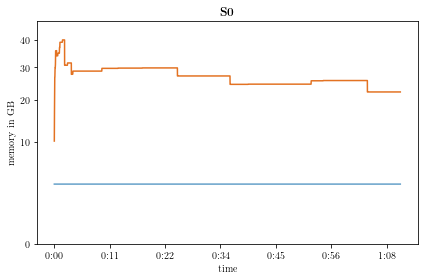

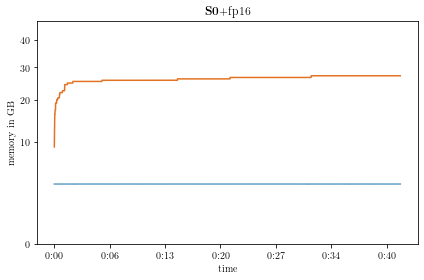

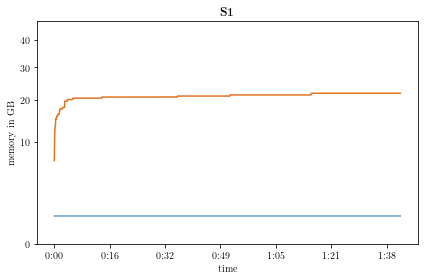

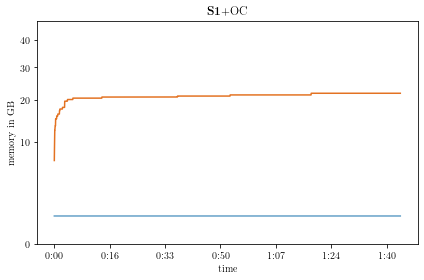

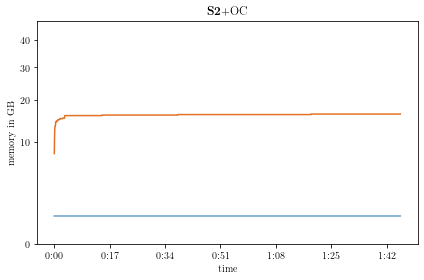

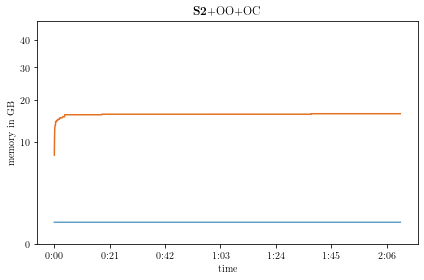

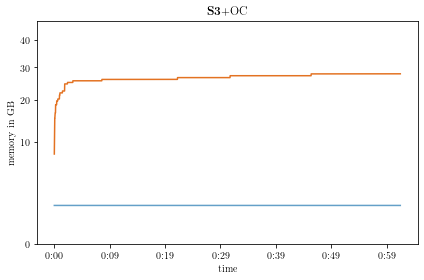

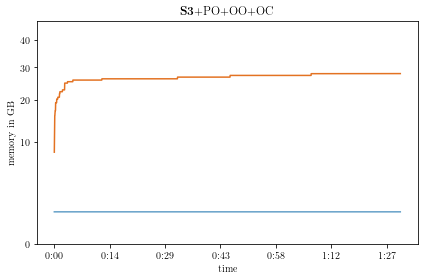

In [10]:
for i, run in enumerate(runs):
    cuda_memory.plot_cuda_memory(
        run, 
        mode="averaged", 
        title=formatted_run_names_1[i],
        save=True, 
        save_dir="../outputs/dimenet/is2re/cuda_memory"
    )

For a single run, the GPU CUDA torch memory consumption can be plotted versus time, individually on each GPU or averaged/summed across all involved GPUs.

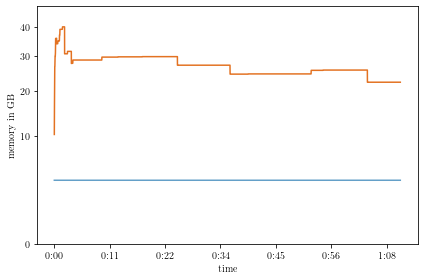

In [11]:
cuda_memory.plot_cuda_memory("S0", mode="averaged")

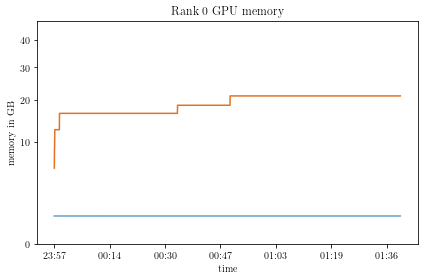

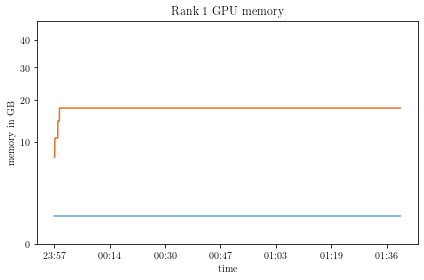

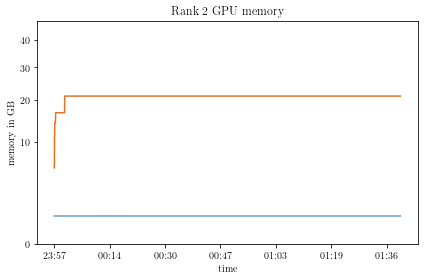

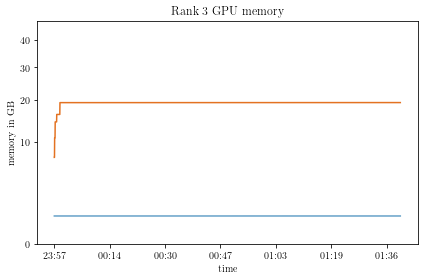

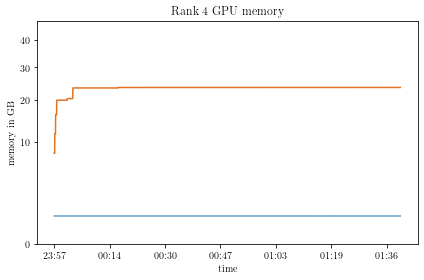

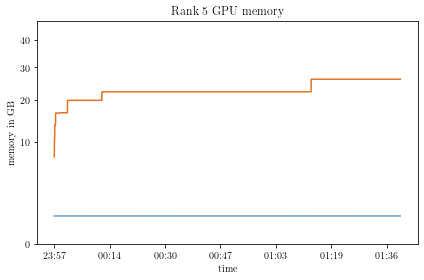

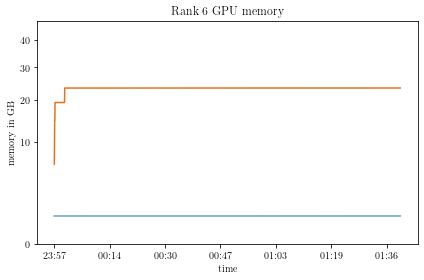

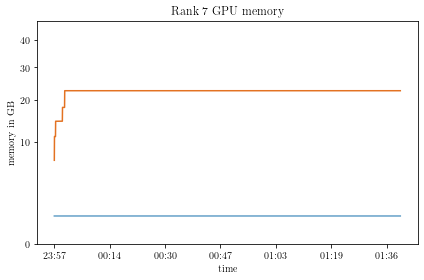

In [12]:
cuda_memory.plot_cuda_memory("S1", mode="individual")

## Comparison of memory and runtimes for different runs

For different runs, the allocated and reserved GPU CUDA memory as well as the runtimes can be compared.

In [13]:
runtimes.compare(save=True, save_dir="../outputs/dimenet/is2re/runtimes")

,S0,S0+fp16,S1,S1+OC,S2+OC,S2+OO+OC,S3+OC,S3+PO+OO+OC
epoch_time,01:11:14,00:42:37,01:42:24,01:45:05,01:46:43,02:12:14,01:01:56,01:31:00
dataloading_time,00:00:10,00:00:12,00:00:50,00:00:52,00:00:47,00:00:43,00:00:06,00:00:08
forward_time,00:07:47,00:05:32,00:06:42,00:06:47,00:06:43,00:06:46,00:17:29,00:17:31
backward_time,00:58:40,00:32:46,00:30:28,00:30:38,00:34:37,00:58:13,00:42:07,01:11:02
rest,00:04:34,00:04:05,01:04:22,01:06:46,01:04:35,01:06:31,00:02:12,00:02:18


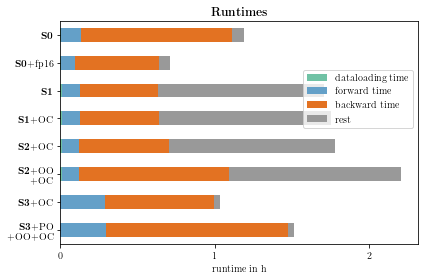

In [14]:
runtimes.compare_plot(
    yticks=formatted_run_names_2, 
    figsize=(6, 4), 
    title=r"\textbf{Runtimes}", 
    save=True, 
    save_dir="../outputs/dimenet/is2re/runtimes"
)

In [15]:
cuda_memory.compare(save=True, save_dir="../outputs/dimenet/is2re/cuda_memory")

,S0,S0+fp16,S1,S1+OC,S2+OC,S2+OO+OC,S3+OC,S3+PO+OO+OC
gpu_memory_allocated,3.46,3.47,0.76,0.76,0.76,0.46,1.44,1.00
gpu_memory_reserved,26.92,26.25,21.08,21.08,16.07,16.20,26.68,26.82


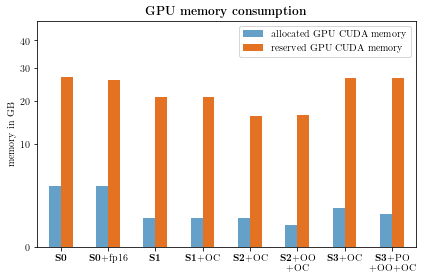

In [16]:
cuda_memory.compare_plot(
    xticks=formatted_run_names_2, 
    figsize=(6, 4), 
    title=r"\textbf{GPU memory consumption}", 
    save=True, 
    save_dir="../outputs/dimenet/is2re/cuda_memory"
)